In [1]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
from statannotations.Annotator import Annotator
import pandas as pd
import brainrender
import scipy.ndimage as ndi
from skimage.morphology import skeletonize
from axon_data import brain2paths, brain2centers
import os
from util import json_to_points
import scipy.ndimage as ndi

%gui qt5

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


embedWindow(verbose=True): could not load ipyvtk_simple try:
> pip install -U git+https://github.com/Kitware/ipyvtk-simple.git


### Convert labels

In [24]:
base_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/full-2022-09-01/brain3/other-brains/brain8649/"
files = os.listdir(base_dir)
files = [base_dir + f for f in files if "_Labels" in f]

for file in files:
    with h5py.File(file) as hf:
        labels = np.array(hf['exported_data'])
    io.imsave(file[:-3] + '.tif', labels)

### Move files 

In [6]:
brain = "8650"
model = "brain3"

base_dir = (
            "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/val/brain"
            + brain
            + "/"
        )

files = os.listdir(base_dir)
files = [f for f in files if "_Probabilities" in f]

move = input(f"Rename {files} to {base_dir}{model}? (y/n)")
if move == "y":
    for file in files:
        os.rename(base_dir + file, f"{base_dir}{model}/{file}")

## PR Curves

10 total validation subvolumes for brain 8650
29 total validation subvolumes for brain 8649
10 total validation subvolumes for brain 8613
10 total validation subvolumes for brain 8589
14 total validation subvolumes for brain 8590
10 total validation subvolumes for brain 8650
29 total validation subvolumes for brain 8649
10 total validation subvolumes for brain 8613
10 total validation subvolumes for brain 8589
14 total validation subvolumes for brain 8590
10 total validation subvolumes for brain 8650
29 total validation subvolumes for brain 8649
10 total validation subvolumes for brain 8613
10 total validation subvolumes for brain 8589
14 total validation subvolumes for brain 8590


<AxesSubplot:xlabel='Recall', ylabel='Precision'>

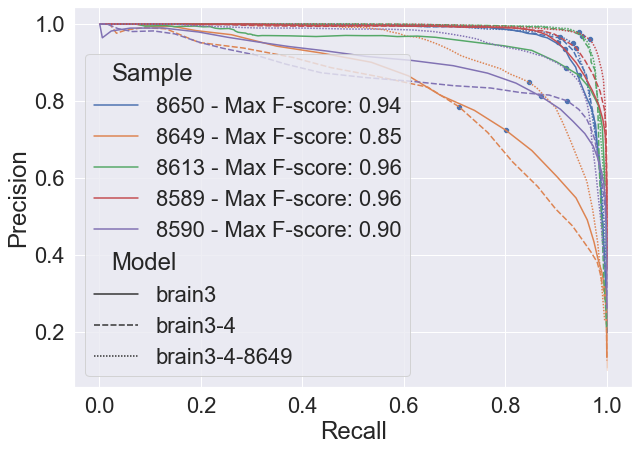

In [25]:
brains = ["8650", "8649", 
    "8613", "8589", "8590"]

model_names = ["brain3", "brain3-4", "brain3-4-8649"]

brain_ids = []
precisions = []
recalls = []
models = []

best_precisions = []
best_recalls = []
best_fscores = {}

for model in model_names: 
    for brain in brains:

        base_dir = (
            "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/val/brain"
            + brain
            + "/"
        )

        spacing = 0.02
        thresholds = np.arange(spacing, 1.0, spacing)
        best_fscore = 0

        files = os.listdir(base_dir)
        files = [f for f in files if "val" in f]
        files = [f for f in files if "_Labels.h5" not in f]
        files = [f for f in files if "_Probabilities.h5" not in f]

        print(f"{len(files)} total validation subvolumes for brain {brain}")

        for threshold in thresholds:
            true_pos_total = 0
            false_pos_total = 0
            true_labels_total = 0
            true_labels_total_neg = 0
            for fname in files:
                fname_im = base_dir + fname
                f = h5py.File(fname_im, "r")
                im = f.get("image_2channel")
                im_bg = im[0, :, :, :]
                im_fg = im[1, :, :, :]

                fname_prob = f"{base_dir}{model}/{fname[:-3]}_Probabilities.h5"
                f = h5py.File(fname_prob, "r")
                seg = f.get("exported_data")
                seg = seg[1, :, :, :]
                mask = seg > threshold

                fname_lab = f"{base_dir}labels/{fname[:-3]}-image_2channel_Labels.h5" 
                f = h5py.File(fname_lab, "r")
                gt = f.get("exported_data")
                gt = gt[0, :, :, :]
                pos_labels = gt == 2
                neg_labels = gt == 1

                true_pos = np.sum(np.logical_and(mask, pos_labels))
                true_pos_total += true_pos
                false_pos = np.sum(np.logical_and(mask, gt == 1))
                false_pos_total += false_pos
                true_labels = np.sum(pos_labels)
                true_labels_total += true_labels
                true_labels_neg = np.sum(neg_labels)
                true_labels_total_neg += true_labels_neg

            precision_total = true_pos_total / (true_pos_total + false_pos_total)
            recall_total = true_pos_total / true_labels_total

            precisions.append(precision_total)
            recalls.append(recall_total)
            brain_ids.append(brain)
            models.append(model)

            fscore = 2 / (1 / precision_total + 1 / recall_total)

            if fscore > best_fscore:
                best_fscore = fscore
                best_prec = precision_total
                best_recall = recall_total
                best_threshold = threshold
        best_precisions.append(best_prec)
        best_recalls.append(best_recall)
        best_fscores[brain] = best_fscore

for i, brain_id in enumerate(brain_ids):
    brain_ids[i] = brain_id + f" - Max F-score: {best_fscores[brain_id]:.2f}"

data = {"Sample": brain_ids, "Recall": recalls, "Precision": precisions, "Model": models}
df = pd.DataFrame(data=data)


sns.set(rc={"figure.figsize": (10, 7)})
sns.set(font_scale=2)
sns.lineplot(data=df, x="Recall", y="Precision", hue="Sample", style="Model")
sns.scatterplot(x=best_recalls, y=best_precisions)

## Change of max f score

10 total validation subvolumes for brain 8650
29 total validation subvolumes for brain 8649
10 total validation subvolumes for brain 8613
10 total validation subvolumes for brain 8589
14 total validation subvolumes for brain 8590
10 total validation subvolumes for brain 8650
29 total validation subvolumes for brain 8649
10 total validation subvolumes for brain 8613
10 total validation subvolumes for brain 8589
14 total validation subvolumes for brain 8590
10 total validation subvolumes for brain 8650
29 total validation subvolumes for brain 8649
10 total validation subvolumes for brain 8613
10 total validation subvolumes for brain 8589
14 total validation subvolumes for brain 8590


<seaborn.axisgrid.FacetGrid object at 0x15e29c760>

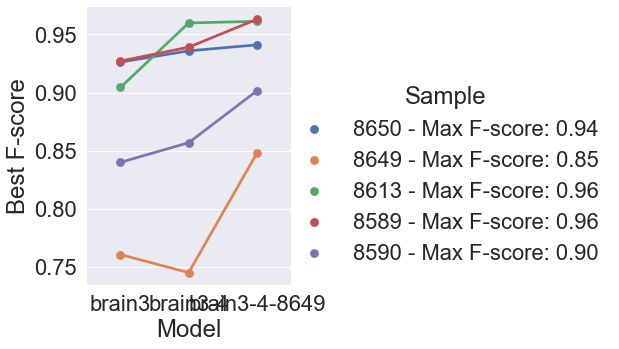

In [26]:
brains = ["8650", "8649", 
    "8613", "8589", "8590"]

model_names = ["brain3", "brain3-4", "brain3-4-8649"]

brain_ids = []
best_fscores = []
models = []

best_precisions = []
best_recalls = []
best_fscores_dict = {}

for model in model_names: 
    for brain in brains:

        base_dir = (
            "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/val/brain"
            + brain
            + "/"
        )

        spacing = 0.02
        thresholds = np.arange(spacing, 1.0, spacing)
        best_fscore = 0

        files = os.listdir(base_dir)
        files = [f for f in files if "val" in f]
        files = [f for f in files if "_Labels.h5" not in f]
        files = [f for f in files if "_Probabilities.h5" not in f]

        print(f"{len(files)} total validation subvolumes for brain {brain}")

        for threshold in thresholds:
            true_pos_total = 0
            false_pos_total = 0
            true_labels_total = 0
            true_labels_total_neg = 0
            for fname in files:
                fname_im = base_dir + fname
                f = h5py.File(fname_im, "r")
                im = f.get("image_2channel")
                im_bg = im[0, :, :, :]
                im_fg = im[1, :, :, :]

                fname_prob = f"{base_dir}{model}/{fname[:-3]}_Probabilities.h5"
                f = h5py.File(fname_prob, "r")
                seg = f.get("exported_data")
                seg = seg[1, :, :, :]
                mask = seg > threshold

                fname_lab = f"{base_dir}labels/{fname[:-3]}-image_2channel_Labels.h5" 
                f = h5py.File(fname_lab, "r")
                gt = f.get("exported_data")
                gt = gt[0, :, :, :]
                pos_labels = gt == 2
                neg_labels = gt == 1

                true_pos = np.sum(np.logical_and(mask, pos_labels))
                true_pos_total += true_pos
                false_pos = np.sum(np.logical_and(mask, gt == 1))
                false_pos_total += false_pos
                true_labels = np.sum(pos_labels)
                true_labels_total += true_labels
                true_labels_neg = np.sum(neg_labels)
                true_labels_total_neg += true_labels_neg

            precision_total = true_pos_total / (true_pos_total + false_pos_total)
            recall_total = true_pos_total / true_labels_total

            fscore = 2 / (1 / precision_total + 1 / recall_total)

            if fscore > best_fscore:
                best_fscore = fscore
                best_prec = precision_total
                best_recall = recall_total
                best_threshold = threshold
        best_fscores.append(best_fscore)
        brain_ids.append(brain)
        models.append(model)

        best_fscores_dict[brain] = best_fscore

for i, brain_id in enumerate(brain_ids):
    brain_ids[i] = brain_id + f" - Max F-score: {best_fscores_dict[brain_id]:.2f}"

data = {"Sample": brain_ids, "Best F-score": best_fscores, "Model": models}
df = pd.DataFrame(data=data)

sns.set(rc={"figure.figsize": (20, 10)})
sns.set(font_scale=2)
sns.catplot(data=df, x="Model", y="Best F-score", hue="Sample", kind="point", height=7)

<seaborn.axisgrid.FacetGrid object at 0x15e9bb550>

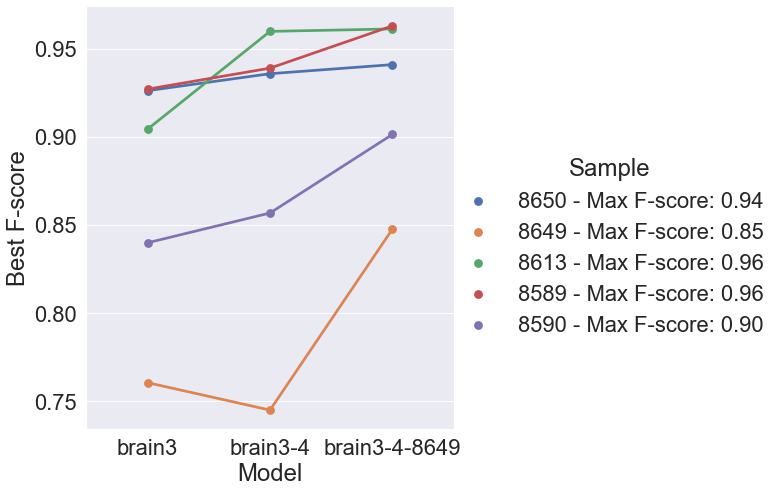

In [36]:

sns.set(rc={"figure.figsize": (20, 10)})
sns.set(font_scale=2)
sns.catplot(data=df, x="Model", y="Best F-score", hue="Sample", kind="point", height=7)